In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import emoji
import string
import spacy
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/student/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('data/mental_health_data.csv', index_col=0)
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
print('Число пропусков в колонке statement:', data['statement'].isna().sum())
print('Число пропусков в колонке status:', data['status'].isna().sum())
data = data.dropna().reset_index().drop(columns='index')

Число пропусков в колонке statement: 362
Число пропусков в колонке status: 0


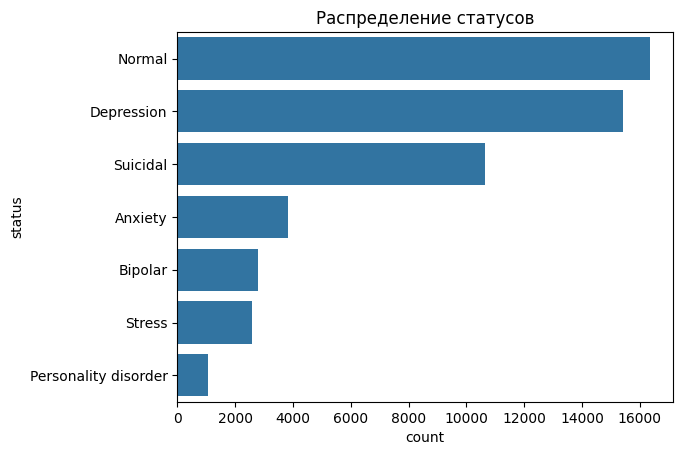

In [4]:
sns.barplot(data['status'].value_counts(), orient='h')
plt.title('Распределение статусов');

Наблюдаем сильный дизбаланс классов.

# Очистка данных

In [2]:
nlp = spacy.load("en_core_web_sm")

english_stopwords = set([
    'a', 'an', 'ain', 'any', 'as', 'at', 'the', 'be' 'but', 'by', 'and', 'for', 'from', 'if', 'in', 'into',
    'have', 'ma', 'of', 'off', 'on', 'once', 'only', 'or', 're', 'same', 'so', 'some', 'such', 'than', 'that', 'to', 'too',
    'under', 'up', 've', 'with', 'y', 'those', 'these', 'this', 'there', 'through' 
])

SELF_HARM_PATTERNS = [
    r'i (hate|dislike) myself',
    r'(want|wish) to die'
]

NameError: name 'spacy' is not defined

In [ ]:
def clean_text(text):
    """
    Полная очистка текста с сохранением эмоционально значимых элементов
    """

    if not isinstance(text, str):
        return ""
    
    # Удаление URL и HTML-тегов
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    
    # Обработка эмодзи (сохраняем их текстовое описание)
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    # Удаление имен пользователей (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Удаление специальных символов (кроме пунктуации)
    text = re.sub(r'[^\w\s.,!?;:\']', '', text)

    # Удаление цифр
    text = re.sub(r'\d+', '', text)
    
    # Приведение к нижнему регистру
    text = text.lower()

    # Расстановка селфхарм флагов
    for pattern in SELF_HARM_PATTERNS:
        if re.search(pattern, text, re.IGNORECASE):
            text = f"[SELF_HARM_FLAG] {text}"
    
    # Лемматизация (сохраняя контекст)
    doc = nlp(text)
    words = [token.lemma_ for token in doc if token.lemma_.lower() not in english_stopwords]
    
    # Удаление пунктуации (кроме эмоционально значимой: ! ? ...)
    translator = str.maketrans('', '', string.punctuation.replace('!', '').replace('?', ''))
    text = ' '.join(words).translate(translator)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Сохранение многоточий как отдельного токена (индикатор депрессивных текстов)
    text = re.sub(r'\.{3,}', ' ... ', text)
    
    return text


def preprocess_dataframe(df, text_column='statement'):
    """
    Обработка всего датафрейма: очистка текста и расчет некоторых числовых характеристик
    """
    
    df_clean = df.copy()
    df_clean['cleaned_text'] = df_clean[text_column].apply(clean_text)
    
    # Дополнительные метрики для анализа
    df_clean['text_length'] = df_clean['cleaned_text'].apply(lambda x: len(x.split()))
    df_clean['exclamation_count'] = df_clean[text_column].apply(lambda x: x.count('!'))
    df_clean['question_count'] = df_clean[text_column].apply(lambda x: x.count('?'))
    df_clean['ellipsis_count'] = df_clean[text_column].apply(lambda x: 1 if '...' in x else 0)
    
    return df_clean

In [17]:
# Очистка данных
data_clean = preprocess_dataframe(data)
data_clean.to_csv('data/mental_health_data_clean.csv', index=False)

data_clean.head()

,statement,status,cleaned_text,text_length,exclamation_count,question_count,ellipsis_count
0,oh my gosh,Anxiety,oh my gosh,3,0,0,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleep confused mind restless heart all...,9,0,0,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back dear forward doubt stay restles...,10,0,0,0
3,I've shifted my focus to something else but I'...,Anxiety,I shift my focus something else but I be still...,11,0,0,0
4,"I'm restless and restless, it's been a month n...",Anxiety,I be restless restless it be be month now boy ...,15,0,1,0


In [18]:
print("Пример очищенных текстов:")
data_clean[['statement', 'cleaned_text']].head()

Пример очищенных текстов:


,statement,cleaned_text
0,oh my gosh,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleep confused mind restless heart all...
2,"All wrong, back off dear, forward doubt. Stay ...",all wrong back dear forward doubt stay restles...
3,I've shifted my focus to something else but I'...,I shift my focus something else but I be still...
4,"I'm restless and restless, it's been a month n...",I be restless restless it be be month now boy ...


In [19]:
# Количество получившихся пропусков
print('Количество пустых текстов после очистки:', (data_clean['cleaned_text'] == '').sum())

# Посмотрим на них
data_clean.loc[data_clean['cleaned_text'] == '', ['statement', 'cleaned_text', 'status']]

Количество пустых текстов после очистки: 7


,statement,cleaned_text,status
8522,37.795120 -122.44502037.794440 -122.43321037.7...,,Suicidal
10332,9111 10335,,Suicidal
32090,"$1,000.",,Normal
36068,@JonathanRKnight,,Normal
36182,https://t.co/6MPqRunPeX https://t.co/6MPqRunPeX,,Suicidal
36401,@ShannonRenee,,Normal
36911,@gypsytrading,,Normal


In [20]:
# Удалим эти строки из данных 
data_clean = data_clean[data_clean['cleaned_text'] != ''].copy()
data_clean.to_csv('data/mental_health_data_clean.csv', index=False)

data_clean.shape

(52674, 7)

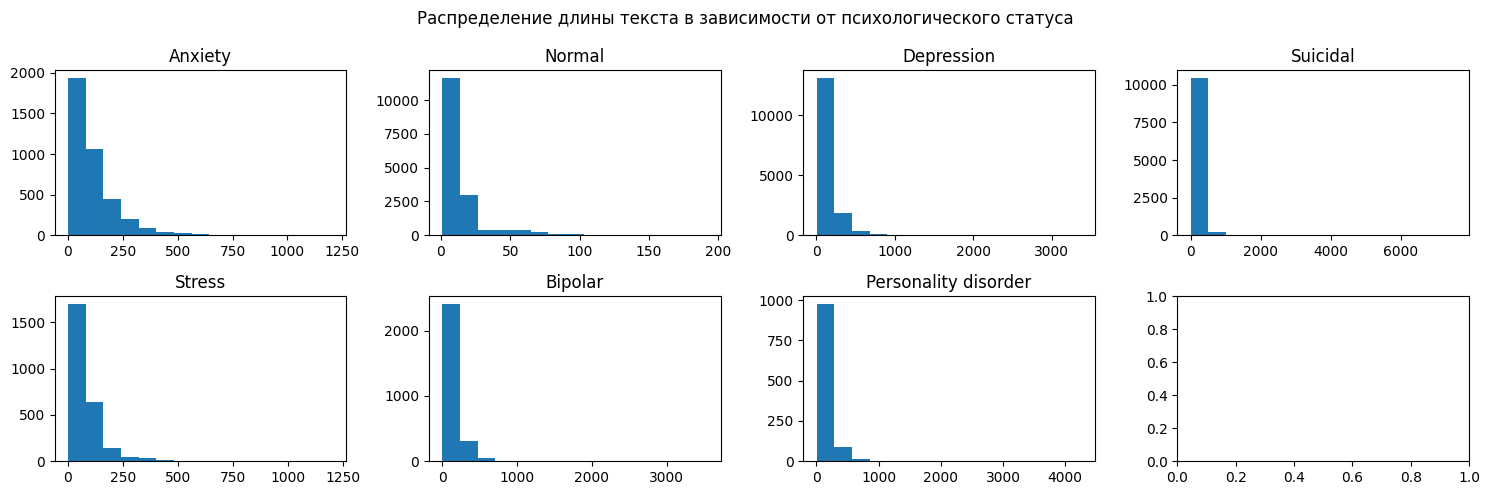

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(15,5))
fig.suptitle('Распределение длины текста в зависимости от психологического статуса')
for ax, status in zip(axes.flatten(), data_clean['status'].unique()):
    ax.hist(data_clean.loc[data_clean['status'] == status, 'text_length'], bins=15)
    ax.set_title(status)
fig.tight_layout()

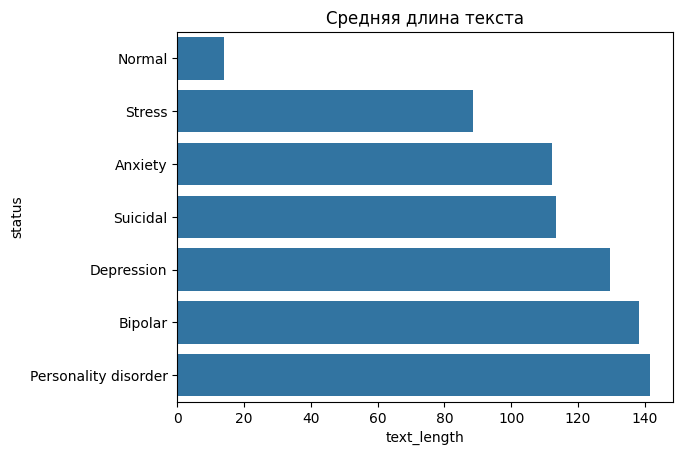

In [22]:
sns.barplot(data_clean.groupby('status')['text_length'].mean().sort_values(), orient='h')
plt.title('Средняя длина текста');

Интересное наблюдение: тексты людей со статусом какого-либо расстройства в среднем гораздо длиннее, чем тексты людей со статусом "Normal".

# Облака слов по статусам

In [23]:
def show_word_cloud(df, status: str):
    text = ' '.join(df.loc[df['status'] == status, 'cleaned_text'].to_list())

    # Сгенерировать облако слов  
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)  
    
    # Отобразить изображение  
    plt.figure(figsize=(10, 5))  
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(status)  
    plt.axis('off')
    plt.show()

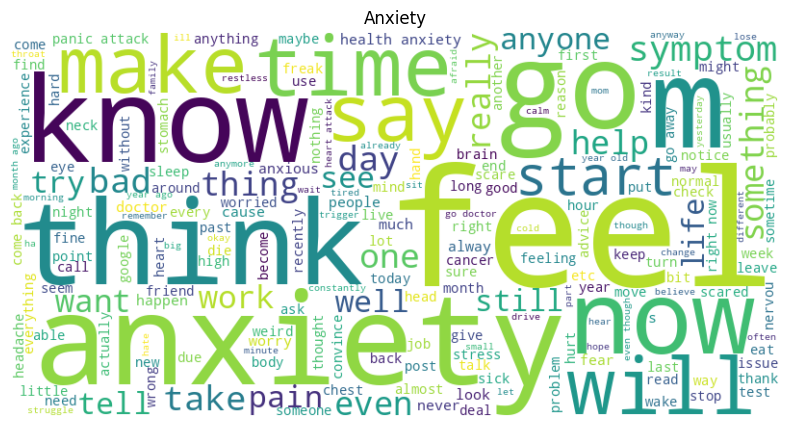

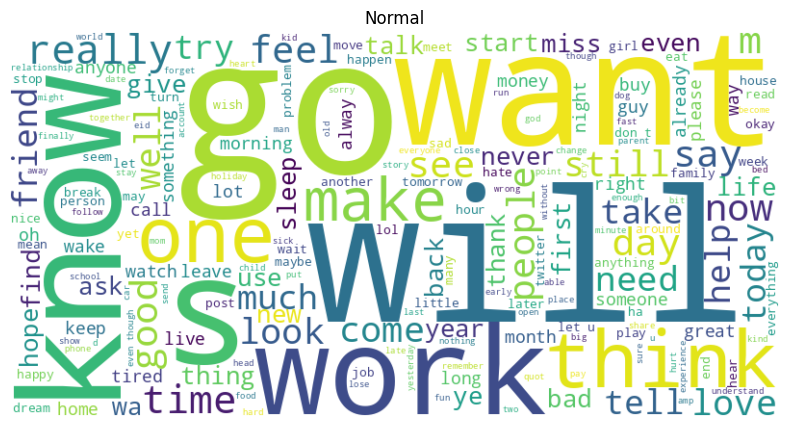

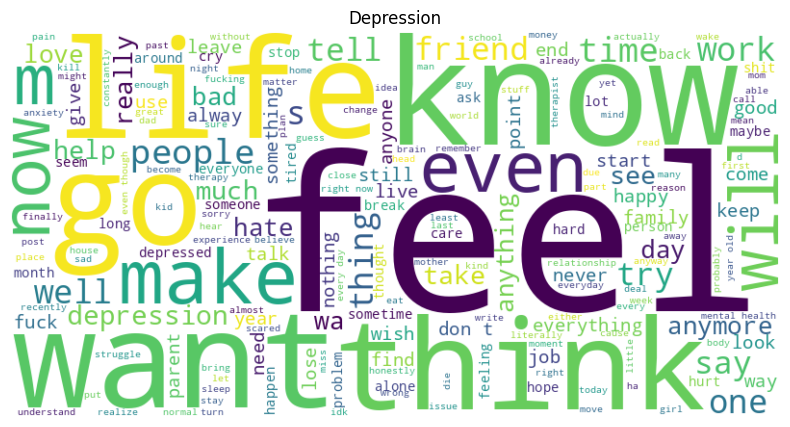

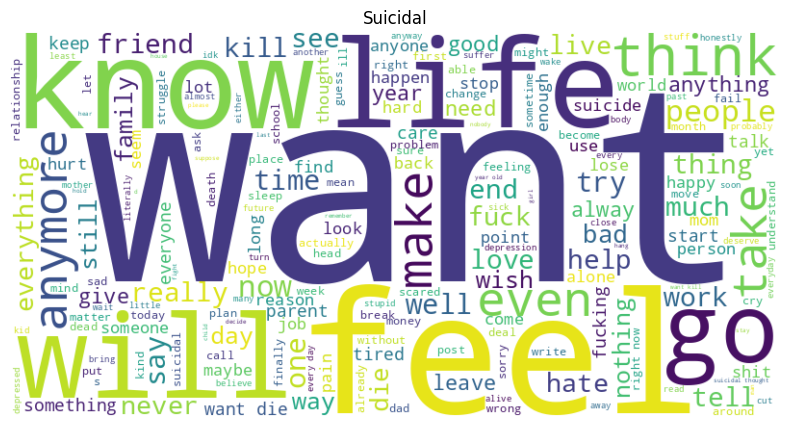

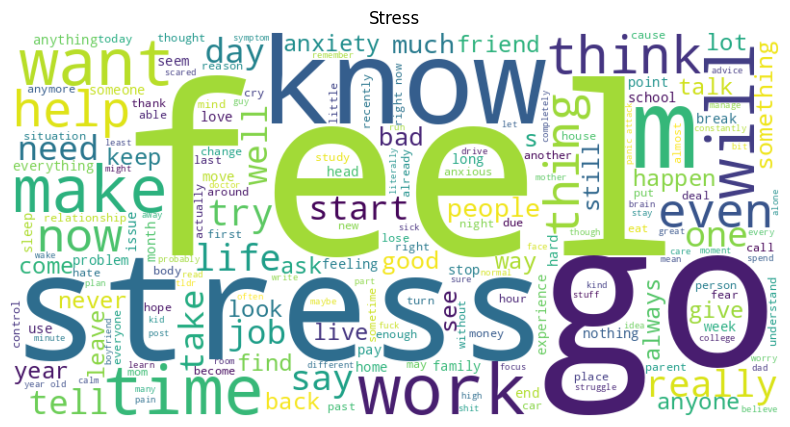

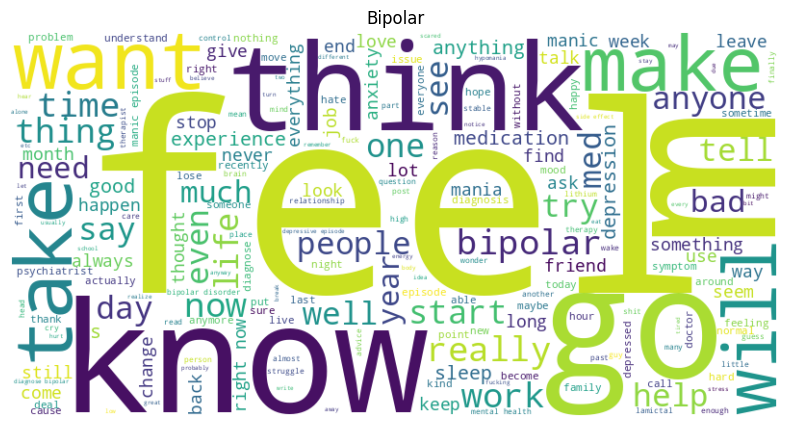

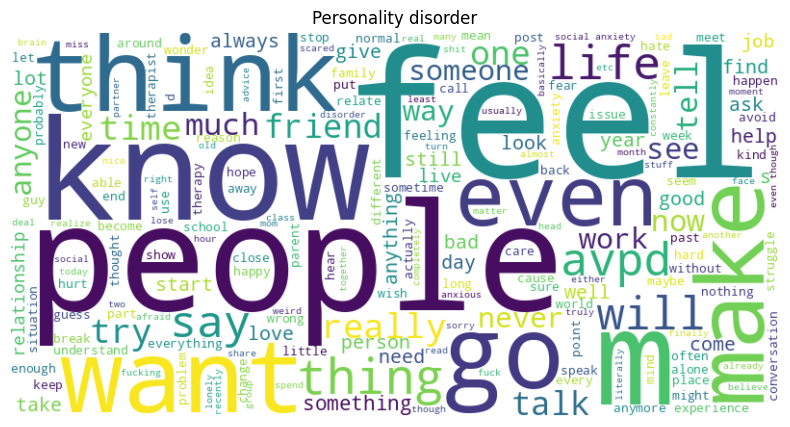

In [24]:
data_clean = pd.read_csv('data/mental_health_data_clean.csv')

for status in data_clean['status'].unique():
    show_word_cloud(data_clean, status)

# Извлечение лингвистических признаков

NOUN - существительное

VERB - глагол

PRON - местоимение

ADJ - прилагательное

In [25]:
nlp = spacy.load("en_core_web_sm")

In [32]:
text = 'I am a programmer'
doc = nlp(text)
Counter(token.text for token in doc if token.text == 'I')

Counter({'I': 1})

In [33]:
def calculate_pos_percentages(text):
    """
    Вычисляет процент глаголов, существительных, всех местоимений, 
    местоимений первого лица (I) и прилагательных в тексте.
    Возвращает словарь с процентами.
    """

    doc = nlp(text)
    
    # Считаем части речи
    pos_counts = Counter(token.pos_ for token in doc if not token.is_punct and not token.is_space)
    i_counts = Counter(token.text for token in doc if token.text == 'I')
    
    total_words = sum(pos_counts.values())
    
    if total_words == 0:
        return {
            'verb_percent': 0,
            'noun_percent': 0,
            'pron_percent': 0,
            'i_pron_percent': 0,
            'adj_percent': 0
        }
    
    # Вычисляем проценты
    adj_percent = (pos_counts.get('ADJ', 0) / total_words) * 100
    pron_percent = (pos_counts.get('PRON', 0) / total_words) * 100
    verb_percent = (pos_counts.get('VERB', 0) / total_words) * 100
    noun_percent = (pos_counts.get('NOUN', 0) / total_words) * 100
    i_pron_percent = (i_counts.get('I', 0) / total_words) * 100
    
    return {
        'verb_percent': round(verb_percent, 2),
        'noun_percent': round(noun_percent, 2),
        'pron_percent': round(pron_percent, 2),
        'i_pron_percent': round(i_pron_percent, 2),
        'adj_percent': round(adj_percent, 2)
    }

In [34]:
parts_percents = pd.DataFrame(data_clean['cleaned_text'].map(calculate_pos_percentages).to_list())
data_expanded = pd.concat([data_clean, parts_percents], axis=1)

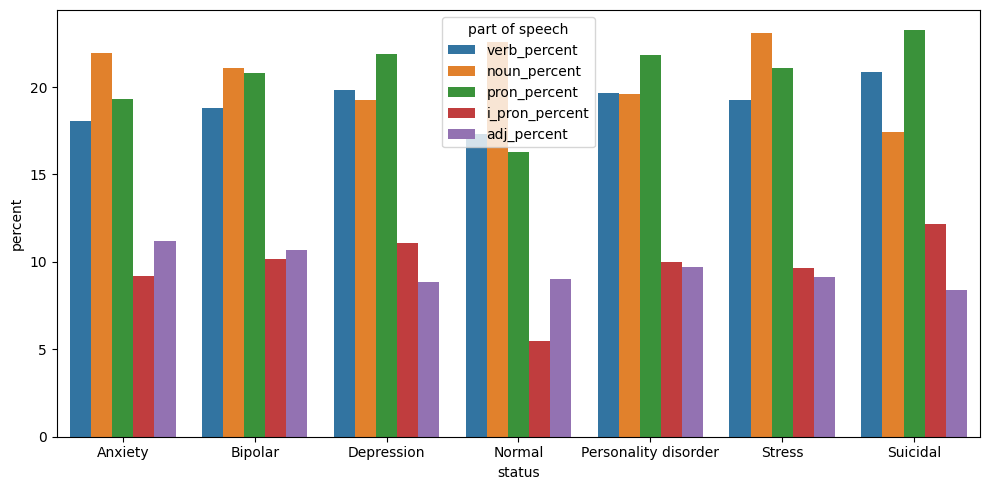

In [36]:
parts_percents_per_status = (
    data_expanded.groupby('status')[['verb_percent', 'noun_percent', 'pron_percent', 'i_pron_percent', 'adj_percent']]
    .mean()
)
parts_percents_per_status = (parts_percents_per_status
                             .reset_index()
                             .melt(id_vars='status', var_name='part of speech', value_name='percent'))

plt.figure(figsize=(10, 5))
sns.barplot(parts_percents_per_status, x='status', y='percent', hue='part of speech')
plt.tight_layout()

Процент содержания разных частей речи в зависимости от статуса примерно одинаковый за исключением двух интересных наблюдений:

1. У людей со статусом "Normal" в текстах заметно ниже процент содержания местоимений "I" и местоимений в целом
2. У людей со статусом "Suicidal" в текстах заметно ниже процент содержания существительных

# Извлечение психологических признаков

In [ ]:
from nrclex import NRCLex

def get_text_top_emotion(text):
    """ Определяет доминирующую эмоцию текста """

    emotion = NRCLex(text)
    top_emotion, score = emotion.top_emotions[0]
    if score == 0:
        return 'neutral'
    return top_emotion

In [40]:
# Определяем эмоциональную окраску каждого текста
data_expanded['top_emotion'] = data_expanded['cleaned_text'].map(get_text_top_emotion)

# Создаем признак "В группе риска" на основе статуса - будем использовать его для бинарной классификации
data_expanded['at_risk'] = (data_expanded['status'] != 'Normal').astype(int)

In [41]:
# Сохраняем расширенный набор
data_expanded.to_csv('data/mental_health_data_expanded.csv', index=False)

# Понижение размерности

Посмотрим на пространство признаков в меньшей размерности.

In [44]:
data_expanded.head(1)

,statement,status,cleaned_text,text_length,exclamation_count,question_count,ellipsis_count,verb_percent,noun_percent,pron_percent,i_pron_percent,adj_percent,top_emotion,at_risk
0,oh my gosh,Anxiety,oh my gosh,3,0,0,0,0.0,0.0,0.0,0.0,0.0,neutral,1


In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
features_embedded = tsne.fit_transform(data_expanded[[
    'text_length', 'exclamation_count', 'question_count', 'ellipsis_count',
    'verb_percent', 'noun_percent', 'pron_percent', 'i_pron_percent', 'adj_percent'
]])

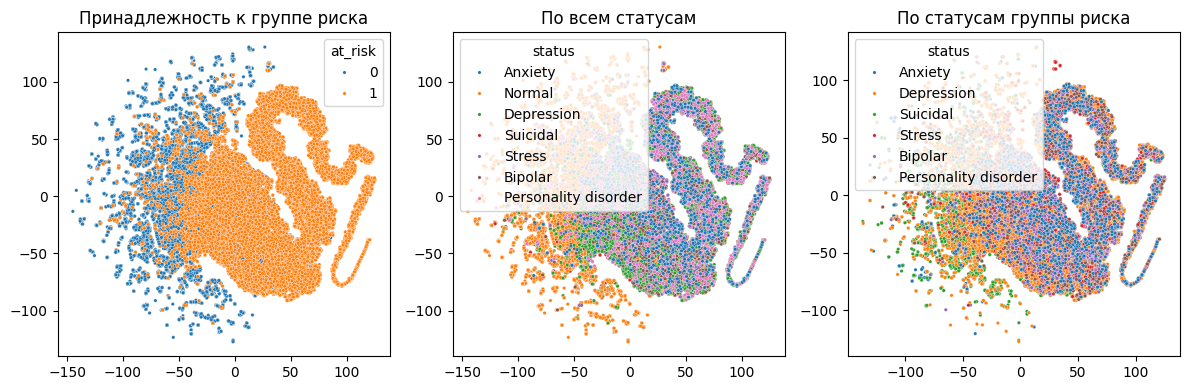

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.scatterplot(x=features_embedded[:, 0], y=features_embedded[:, 1], hue=data_expanded['at_risk'], ax=axes[0], s=6)
axes[0].set_title('Принадлежность к группе риска')

sns.scatterplot(x=features_embedded[:, 0], y=features_embedded[:, 1], hue=data_expanded['status'], ax=axes[1], s=6)
axes[1].set_title('По всем статусам')

at_risk_mask = data_expanded['at_risk'].astype(bool)
sns.scatterplot(x=features_embedded[at_risk_mask, 0], y=features_embedded[at_risk_mask, 1], hue=data_expanded.loc[at_risk_mask, 'status'], ax=axes[2], s=6)
axes[2].set_title('По статусам группы риска')
fig.tight_layout()

Видим, что по построенным признакам уже довольно неплохо можно отличить нормальное состояние от статуса в группе риска. Далее же различные психологические состояния по построенным признакам отличаются меньше.